In [23]:
import numpy as np 
import os 
class OxidationSimulation:
    def __init__(self, out, elements=None, temperature=1000, grid_size=(110, 100), alloy_type='CoCrFeMnNi'):
        self.temperature = temperature
        self.height, self.width = grid_size
        self.alloy_type = alloy_type
        self.out = out
        os.makedirs(self.out, exist_ok=True)
        
        if elements is None:
            if alloy_type == 'CoCrFeMnNi':
                self.elements = [
                    {"symbol": "Co", "percentage": 20},
                    {"symbol": "Cr", "percentage": 20},
                    {"symbol": "Fe", "percentage": 20},
                    {"symbol": "Mn", "percentage": 20},
                    {"symbol": "Ni", "percentage": 20}
                ]
            elif alloy_type == 'CoCrFeCuNi':
                self.elements = [
                    {"symbol": "Co", "percentage": 20},
                    {"symbol": "Cr", "percentage": 20},
                    {"symbol": "Fe", "percentage": 20},
                    {"symbol": "Cu", "percentage": 20},
                    {"symbol": "Ni", "percentage": 20}
                ]
            else:
                raise ValueError("alloy_type must be 'CoCrFeMnNi' or 'CoCrFeCuNi'")
        else:
            self.elements = elements
        
        # Set oxygen diffusion rates based on alloy type
        if 'Cr' in alloy_type:
            # Cr-based alloys have lower oxygen diffusion due to formation of protective Cr2O3
            if 'Mn' in alloy_type:
                # Mn presence increases oxygen diffusion slightly
                self.oxygen_diffusion_rate = 0.0010
            else:
                self.oxygen_diffusion_rate = 0.0008
        else:
            self.oxygen_diffusion_rate = 0.0012
        
        self.initialize_element_properties()
        self.initialize_grid()
        self.iteration = 0
        
    def initialize_element_properties(self):
        # Define stability based on alloy type - higher number means more stable oxide
        if self.alloy_type == 'CoCrFeMnNi':
            stability = {"Cr": 5, "Mn": 4,  "Fe": 3,"Co": 2,"Ni": 1  }
            
            diffusion_coefficients = {
                "O_through_Cr": 2.0e-17,
                "O_through_Mn": 3.0e-12,
                "O_through_Fe": 2.8e-15,
                "O_through_Co": 5.0e-15,
                "O_through_Ni": 6.0e-15,
            }
            
            activation_energies = {
                "O_through_Cr": 180e3,
                "O_through_Mn": 110e3,
                "O_through_Fe": 130e3,
                "O_through_Co": 150e3,
                "O_through_Ni": 160e3,
            }
            
            
        else:  
            stability = {"Cr": 5,  "Fe": 4,"Cu": 3,"Co": 2,"Ni": 1 }
            
            diffusion_coefficients = {
                "O_through_Cr": 2.0e-17,
                "O_through_Fe": 2.8e-15,
                "O_through_Cu": 4.0e-15,
                "O_through_Co": 5.0e-15,
                "O_through_Ni": 6.0e-15,                
            }
            
            activation_energies = {
                "O_through_Cr": 180e3,
                "O_through_Fe": 130e3,
                "O_through_Cu": 120e3,
                "O_through_Co": 150e3,
                "O_through_Ni": 160e3,
            }
            
        self.primary_oxide = "Cr"
        
        T_ref = 1000.0 
        temp_factor = 0.8 
        
        for key, D_ref in diffusion_coefficients.items():
            if key.startswith("O_through"):
                continue 
                
            Q = activation_energies.get(key, 150e3)  
            D_adjusted = D_ref * np.exp(-Q / R * (1/self.temperature - 1/T_ref) * temp_factor)
            diffusion_coefficients[key] = D_adjusted
        
        diffusion_probabilities = {}
        for key, value in diffusion_coefficients.items():
            if any(oxide in key for oxide in ["Co", "Mn", "Fe", "Cu" , "Ni"]):
                prob = value * 2e11
            else:
                prob = value * 2.5
            diffusion_probabilities[key] = min(prob, 0.05)  
        
        diffusion_probabilities[f"O_through_{self.primary_oxide}"] = self.oxygen_diffusion_rate
        
        print(diffusion_probabilities)
        
        self.stability = stability
        self.diffusion_coefficients = diffusion_coefficients
        self.diffusion_probabilities = diffusion_probabilities
        
        # Set reduction factor based on alloy type
        if "Mn" in self.alloy_type:
            self.reduction_factor = 0.003 
             # Higher reduction factor for Mn-containing alloy
            # Lower for Cu-containing alloy due to less internal oxidation
        else:
            self.reduction_factor = 0.001  
        
        self.element_indices = {}
        self.oxide_indices = {}
        
        for i, elem in enumerate(self.elements):
            symbol = elem["symbol"]
            self.element_indices[symbol] = i + 1
            self.oxide_indices[symbol] = i + 6
            
        self.AIR = 0
        
    def initialize_grid(self):
        self.grid = np.zeros((self.height, self.width), dtype=int)
        metal_height = int(self.height * 0.82)
        metal_cells = np.zeros(metal_height * self.width, dtype=int)
        start_idx = 0
        for elem in self.elements:
            symbol = elem["symbol"]
            percentage = elem["percentage"]
            num_cells = int((percentage / 100) * metal_cells.size)
            metal_cells[start_idx:start_idx + num_cells] = self.element_indices[symbol]
            start_idx += num_cells
        np.random.shuffle(metal_cells)
        self.grid[-metal_height:, :] = metal_cells.reshape(metal_height, self.width)
        
    def run_iteration(self):
        new_grid = self.grid.copy()
        
        for i in range(self.height):
            for j in range(self.width):
                cell_val = self.grid[i, j]
                
                # Metal oxidation at air interface
                if 1 <= cell_val <= 5:
                    neighbors = []
                    # Check only adjacent cells (not diagonals)
                    for di, dj in [(-1, 0), (0, -1), (0, 1), (1, 0)]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < self.height and 0 <= nj < self.width:
                            neighbors.append(self.grid[ni, nj])
                                
                    if self.AIR in neighbors:
                        metal_symbol = next((elem["symbol"] for elem in self.elements 
                                           if self.element_indices[elem["symbol"]] == cell_val), None)
                        if metal_symbol:
                            # Oxidation probability varies by element and temperature
                            base_probability = 0.15
                            stability_modifier = self.stability.get(metal_symbol, 3) / 5.0  # Normalize to 0-1
                            temp_effect = (self.temperature / 1000) ** 0.3  # Small temperature effect
                            oxidation_prob = base_probability * stability_modifier * temp_effect
                            
                            if np.random.rand() < oxidation_prob:
                                new_grid[i, j] = self.oxide_indices[metal_symbol]
                
                # Oxide diffusion into metal
                elif 6 <= cell_val <= 10:
                    # Oxide penetration primarily downward
                    directions = [(1, 0)]  # Primarily downward direction
                    for di, dj in directions:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < self.height and 0 <= nj < self.width and 1 <= self.grid[ni, nj] <= 5:
                            # Find the oxide type and metal neighbor
                            oxide_symbol = next((key for key, idx in self.oxide_indices.items() 
                                               if idx == cell_val), None)
                            metal_neighbor_symbol = next((key for key, idx in self.element_indices.items() 
                                                     if idx == self.grid[ni, nj]), None)
                            
                            if oxide_symbol and metal_neighbor_symbol:
                                # Get diffusion probability for this oxide type
                                diffusion_key = f"O_through_{oxide_symbol}"

                                # Calculate temperature effect on diffusion
                                temp_modifier = (self.temperature / 600) ** 0.5
                                base_prob = self.diffusion_probabilities.get(diffusion_key, 0.001)
                                # Calculate final probability with temperature effect
                                prob = min(base_prob * temp_modifier, 0.12)
                                
                                if np.random.rand() < prob:
                                    new_grid[ni, nj] = self.oxide_indices[metal_neighbor_symbol]
                    
                    # Oxide exchange reactions - competitive oxidation
                    for di, dj in [(-1, 0), (0, -1), (0, 1), (1, 0)]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < self.height and 0 <= nj < self.width:
                            neighbor_val = self.grid[ni, nj]
                            if 1 <= neighbor_val <= 5:
                                # Get the current oxide and neighboring metal
                                current_oxide_sym = next((key for key, idx in self.oxide_indices.items() 
                                                         if idx == cell_val), None)
                                neighbor_metal_sym = next((key for key, idx in self.element_indices.items() 
                                                          if idx == neighbor_val), None)
                                
                                # Check if neighbor metal forms more stable oxide
                                if (current_oxide_sym and neighbor_metal_sym and 
                                    self.stability[neighbor_metal_sym] > self.stability[current_oxide_sym]):
                                    
                                    # Calculate reduction probability
                                    stability_diff = self.stability[neighbor_metal_sym] - self.stability[current_oxide_sym]
                                    temp_effect = np.exp((self.temperature - 600) / 300)
                                    
                                    reduction_prob = self.reduction_factor * stability_diff * temp_effect
                                    
                                    if np.random.rand() < reduction_prob:
                                        # Exchange reaction: oxide reduced, neighbor oxidized
                                        new_grid[i, j] = self.element_indices[current_oxide_sym]
                                        new_grid[ni, nj] = self.oxide_indices[neighbor_metal_sym]
        
        self.grid = new_grid
        self.iteration += 1
        
    def run_simulation(self, num_iterations, save_interval=1000):
        start_time = datetime.now()
        for i in range(num_iterations):
            self.run_iteration()
            if i % save_interval == 0 or i == num_iterations - 1:
                print(f"Iteration {i+1}/{num_iterations} - {(i+1)/num_iterations*100:.1f}% complete")
                self.save_output(i)
        elapsed_time = datetime.now() - start_time
        print(f"Simulation completed in {elapsed_time}")
    
    def save_output(self, iteration):
        data_dict = {"fullgrid": self.grid.copy()}
        for elem in self.elements:
            symbol = elem["symbol"]
            mask = (self.grid == self.oxide_indices[symbol]).astype(np.uint8)
            data_dict[symbol] = mask
        npy_filename = f"{self.out}/iter_{iteration}.npy"
        np.save(npy_filename, data_dict)

temperatures = [600, 700, 800, 900, 1000]
alloy_types = ["CoCrFeMnNi", "CoCrFeCuNi"]
elements = None

for alloy in alloy_types:
    for temp in temperatures:
        print(f"Running simulation for alloy: {alloy}, temperature: {temp}")
        out = f"/kaggle/working/{alloy}_{temp}"
        sim = OxidationSimulation(
            out=out,
            elements=elements,
            temperature=temp,
            grid_size=(110, 100),
            alloy_type=alloy
        )
        sim.run_simulation(num_iterations=40000, save_interval=100)
    #     break
    # break
    print("-"*130)


Running simulation for alloy: CoCrFeMnNi, temperature: 600
{'O_through_Cr': 0.001, 'O_through_Mn': 0.05, 'O_through_Fe': 0.0005600000000000001, 'O_through_Co': 0.001, 'O_through_Ni': 0.0012}


NameError: name 'datetime' is not defined

In [22]:
diffusion_coefficients = {
                "O_through_Cr": 2.0e-17,
                "O_through_Fe": 2.8e-15,
                "O_through_Cu": 4.0e-15,
                "O_through_Co": 5.0e-15,
                "O_through_Ni": 6.0e-15,                
}
 

diffusion_probabilities = {}
for key, value in diffusion_coefficients.items():
    if any(oxide in key for oxide in ["Co", "Mn", "Fe", "Cu" , "Ni"]):
        # Scale for oxide diffusion
        prob = value * 2e11
    else:
        prob = value * 2.5
    diffusion_probabilities[key] = min(prob, 0.05)  # Cap at 5%

diffusion_probabilities["O_through_Cr"] = 0.001

print(diffusion_probabilities)

{'O_through_Cr': 0.001, 'O_through_Fe': 0.0005600000000000001, 'O_through_Cu': 0.0008, 'O_through_Co': 0.001, 'O_through_Ni': 0.0012}


In [5]:
0.01-0.008

0.002

In [ ]:
x =  np.load("iter_102300.npy" , allow_pickle=True).item()

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(x["fullgrid"])

In [9]:
import re 
path = "results/CoCrFeMnNi_1000"
files  = os.listdir(path)
files_list = sorted(
    files,
    key=lambda x: int(re.search(r'iter_(\d+)', x).group(1)) if re.search(r'iter_(\d+)', x) else float('inf'),
    reverse=False
)


In [19]:
index=5000
filep = os.path.join(path , f"iter_{index}.npy")

x = np.load(filep , allow_pickle=True).item()

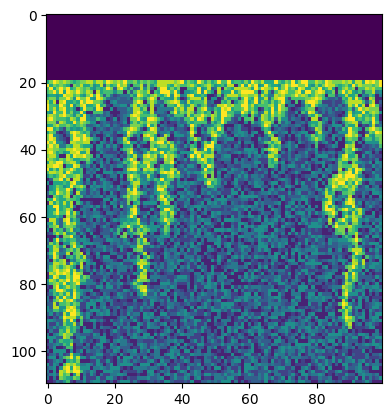

In [20]:
plt.imshow(x["fullgrid"])

In [13]:
import matplotlib.pyplot as plt 